Import libs

In [1]:
import numpy as np
import pandas as pd  
from matplotlib import pyplot as plt
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
import os
from __init__ import root_dir, data_path, src_path
os.path.abspath(root_dir)
from src.models.utils import compute_error, get_data_for_component, preprocess
%load_ext autoreload
%autoreload 2

Read data

In [2]:
#X_numpy = pd.read_csv(os.path.join(data_path,'processed','data_processed.csv'),parse_dates=['datetime'])
X_numpy = pd.read_csv(os.path.join(data_path,'processed','labeled_1h_data.csv'),parse_dates=['datetime'])

X_numpy = X_numpy.drop(columns=['Unnamed: 0'])
N, D = X_numpy.shape
print("Vector of", N, "x", D)

Vector of 874906 x 45


In [3]:
X_numpy.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'voltmean_3h', 'voltsd_3h', 'rotatemean_3h', 'rotatesd_3h',
       'pressuremean_3h', 'pressuresd_3h', 'vibrationmean_3h',
       'vibrationsd_3h', 'voltmean_24h', 'voltsd_24h', 'rotatemean_24h',
       'rotatesd_24h', 'pressuremean_24h', 'pressuresd_24h',
       'vibrationmean_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'model', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'comp1_maint', 'comp2_maint', 'comp3_maint', 'comp4_maint',
       'failure_comp1', 'failure_comp2', 'failure_comp3', 'failure_comp4',
       'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life'],
      dtype='object')

Choose scope-target of the model and keep only the corresponding columns

In [4]:
classification=True#flag if we want to predict lifespan or not
if classification==False:
    X_numpy.dropna(axis=0, inplace=True)
X0 = get_data_for_component(X_numpy, component=4)
X0.shape



(874906, 29)

Split and std data 

In [5]:

y, X, X_train_torch, y_train_torch,X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean=preprocess(X0.copy(),0.1,classi=classification,splitting=True)


(778678, 27) (778678,) (87485, 27) (87485,)


Test

In [6]:

#y, X, X_train_torch, y_train_torch,X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean=preprocess(X0.copy(),0.1,classi=classification,splitting=False)


Define models, train and test them

In [7]:
from src.models.train_model import  lg_c 
from src.models.test_model import  test_c,test_model_c,evaluate

#baseline model
logreg_c=lg_c(X_train_torch, y_train_torch)
y_hat=logreg_c.predict(X_test_torch)
test_c(y_hat,y_test)
evaluate(y_hat,y_test)


predictions: [0. 0. 0. ... 0. 0. 0.]
true values: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.9977824769960565
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[86893    88]
 [  106   398]]
accuracy: 0.9977824769960565
precision: 0.8189300411522634
recall: 0.7896825396825397
f1 score: 0.804040404040404


In [8]:
from src.models.test_model import test_nn_c, test_nn_beta, mae_test, plot_pred
# Define guide functi
from src.models.train_model import train_nn


modelFFNN_c,guide=train_nn("modelFFNN_c", X_train_torch, y_train_torch)


y_pred=test_nn_c(modelFFNN_c,guide,X_test_torch,thres=0.01)
evaluate(y_pred,y_test)

[0] ELBO: 660055.6
[500] ELBO: 12564.3
[1000] ELBO: 10648.1
[1500] ELBO: 9799.3
predictions: [0. 0. 0. ... 0. 0. 0.]
true values: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.9914385323198263
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[86268    18]
 [  731   468]]
accuracy: 0.9914385323198263
precision: 0.9629629629629629
recall: 0.390325271059216
f1 score: 0.5554896142433234


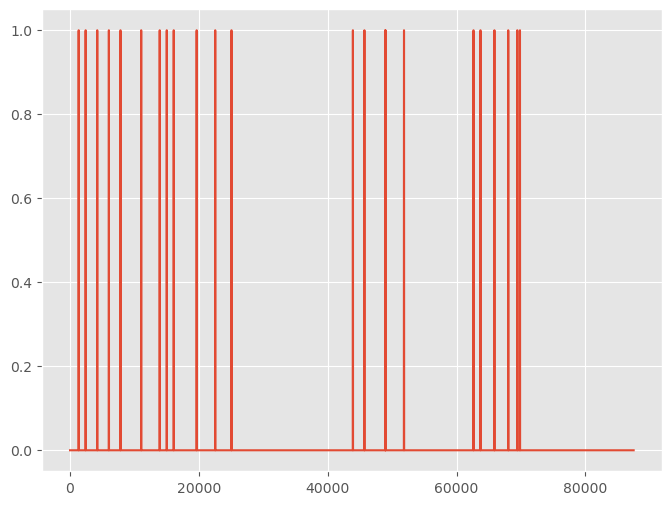

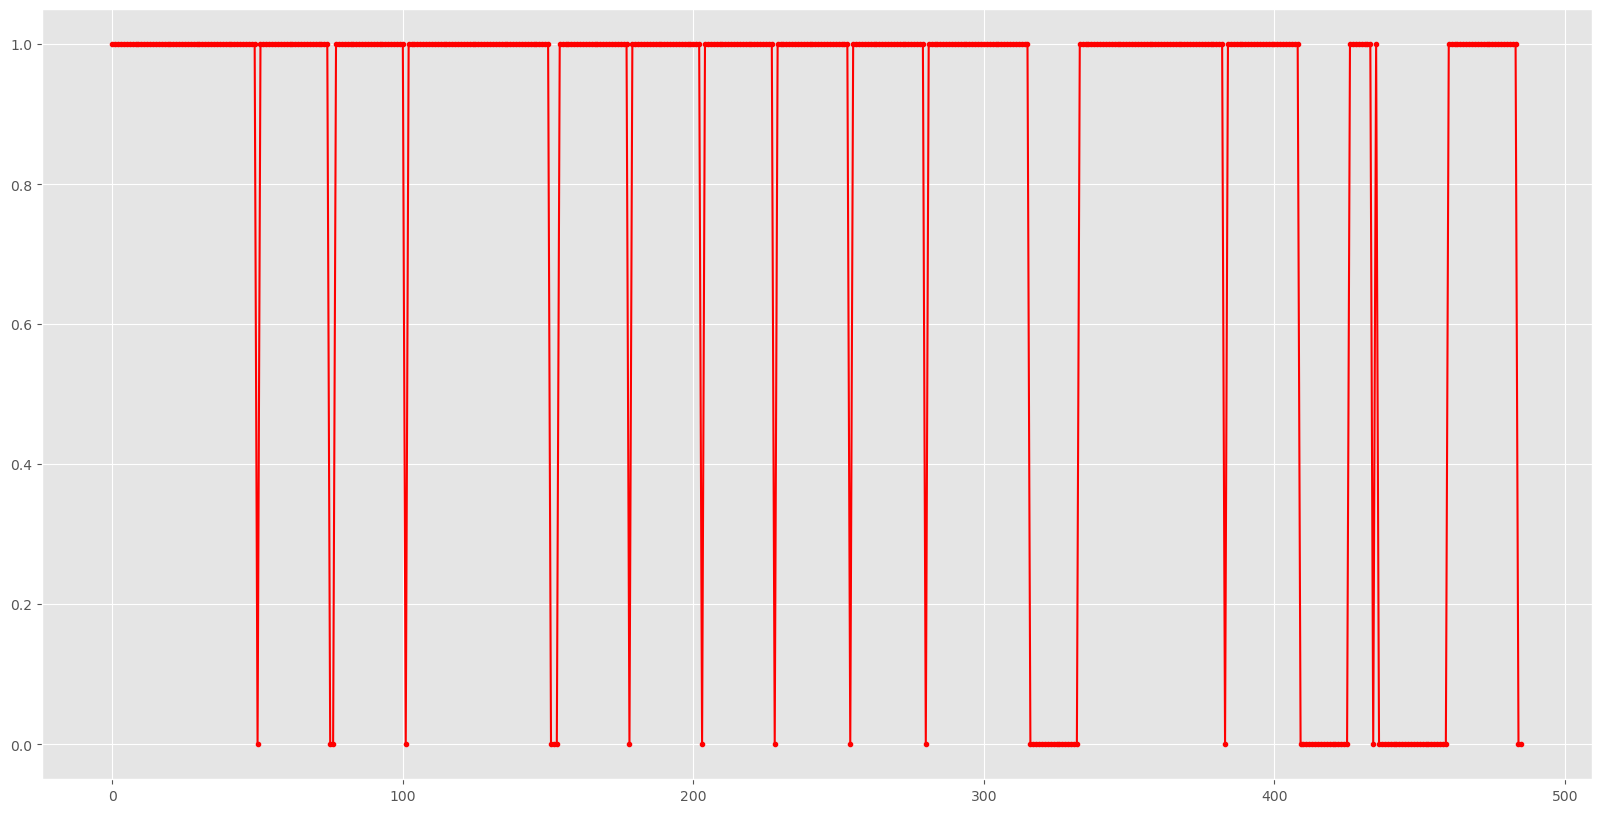

Confusion matrix
- x-axis is true labels (no failure, failure)
- y-axis is predicted labels
[[86935    74]
 [   64   412]]
accuracy: 0.9984225867291535
precision: 0.8477366255144033
recall: 0.865546218487395
f1 score: 0.8565488565488566


In [16]:
y_pred=test_nn_c(modelFFNN_c,guide,X_test_torch,thres=0.5)

plt.plot(y_pred)
fig = plt.figure(figsize=(20, 10))
plt.plot(y_pred[y_test>0], 'r.-', label='test')
plt.show()
evaluate(y_pred,y_test)

Training categorical model with svi

For the training phase are required 10000 steps while learning rate was set to 0.001
After multiple runs, we identified that more steps and or lower learning rate didn't 
improve the results significantly, while the time required was increased.


In [10]:
from src.models.models import model_cat, model_bin_lr, model_cdf
from src.models.train_model import train_c_svi

model__cat,guide_cat, alpha_hat_cat, beta_hat_cat=train_c_svi(model_cat, X_train_torch, y_train_torch.squeeze(),steps=10000,lrate=0.001)

[0] ELBO: 982644.1
[1000] ELBO: 94134.0
[2000] ELBO: 17865.9
[3000] ELBO: 8636.5
[4000] ELBO: 5524.9
[5000] ELBO: 4617.2
[6000] ELBO: 4444.5
[7000] ELBO: 4414.4
[8000] ELBO: 4397.0
[9000] ELBO: 4396.9


Test categorical model with svi


Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[86894    87]
 [  105   399]]
accuracy: 0.9978053380579528
precision: 0.8209876543209876
recall: 0.7916666666666666
f1 score: 0.8060606060606059


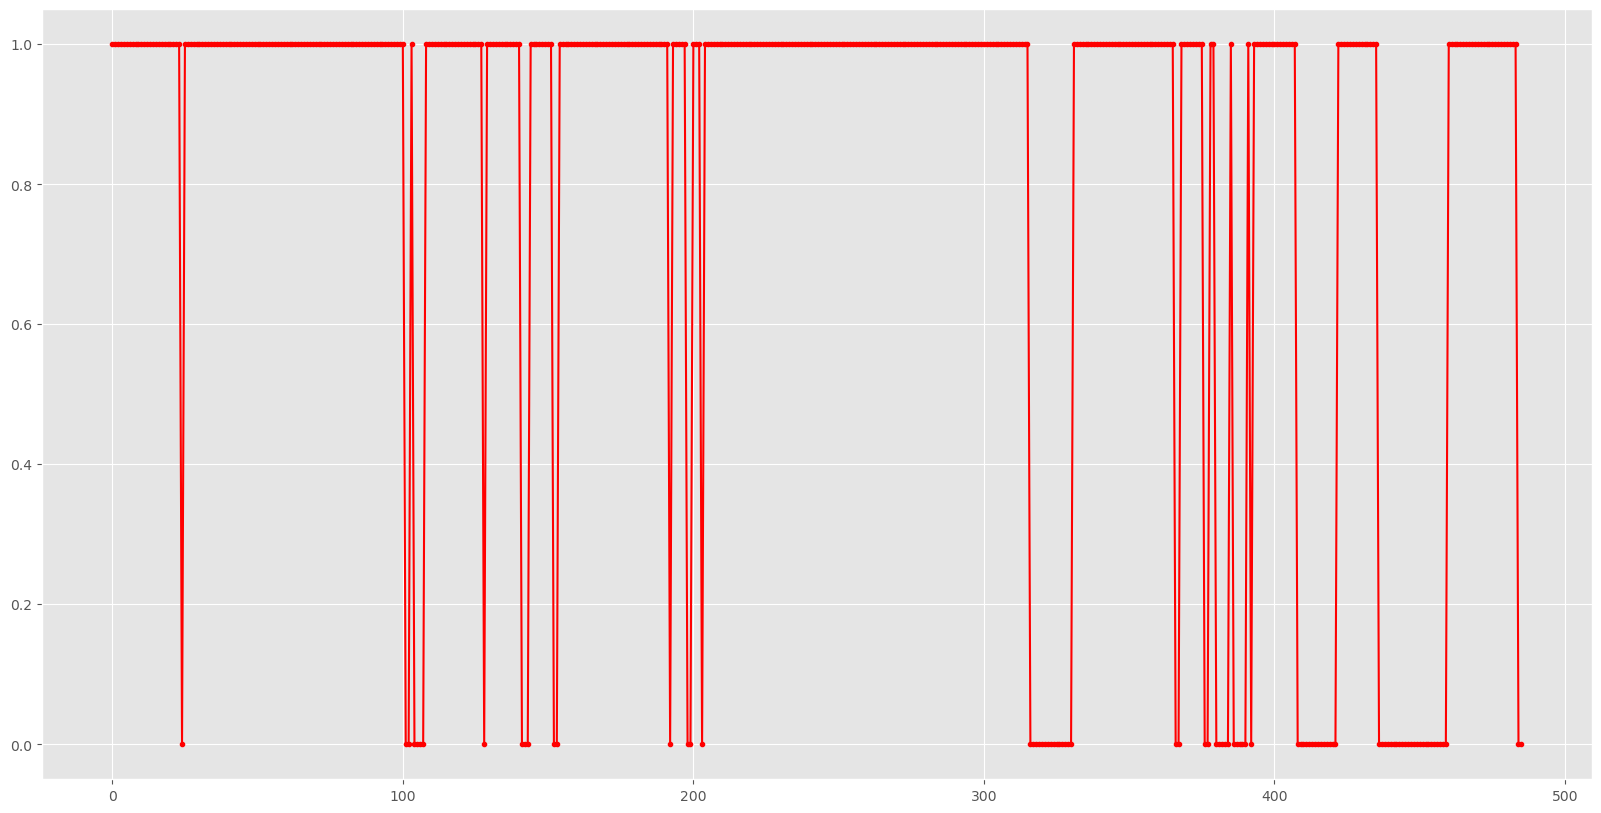

In [11]:
y_hat=test_model_c(alpha_hat_cat, beta_hat_cat,X_test_torch)
evaluate(y_hat,y_test)
fig = plt.figure(figsize=(20, 10))
plt.plot(y_hat[y_test>0], 'r.-', label='test')
plt.show()


In [12]:

model__bin,guide_bin, alpha_hat_bin, beta_hat_bin=train_c_svi(model_bin_lr, X_train_torch, y_train_torch.squeeze(),steps=30000,lrate=0.001)

[0] ELBO: 1006403.3
[1000] ELBO: 305455.7
[2000] ELBO: 141868.2
[3000] ELBO: 56875.6
[4000] ELBO: 26901.9
[5000] ELBO: 14709.9
[6000] ELBO: 8836.8
[7000] ELBO: 6777.1
[8000] ELBO: 5637.4
[9000] ELBO: 5024.6
[10000] ELBO: 4689.7
[11000] ELBO: 4536.2
[12000] ELBO: 4430.4
[13000] ELBO: 4394.2
[14000] ELBO: 4382.4
[15000] ELBO: 4381.9
[16000] ELBO: 4383.9
[17000] ELBO: 4383.0
[18000] ELBO: 4380.0
[19000] ELBO: 4379.9
[20000] ELBO: 4380.6
[21000] ELBO: 4381.5
[22000] ELBO: 4383.5
[23000] ELBO: 4381.1
[24000] ELBO: 4378.8
[25000] ELBO: 4384.3
[26000] ELBO: 4380.6
[27000] ELBO: 4381.5
[28000] ELBO: 4381.1
[29000] ELBO: 4384.2


Confusion matrix
- x-axis is true labels (no failure, failure)
- y-axis is predicted labels
[[86893    89]
 [  106   397]]
accuracy: 0.9977710464651083
precision: 0.8168724279835391
recall: 0.7892644135188867
f1 score: 0.8028311425682507


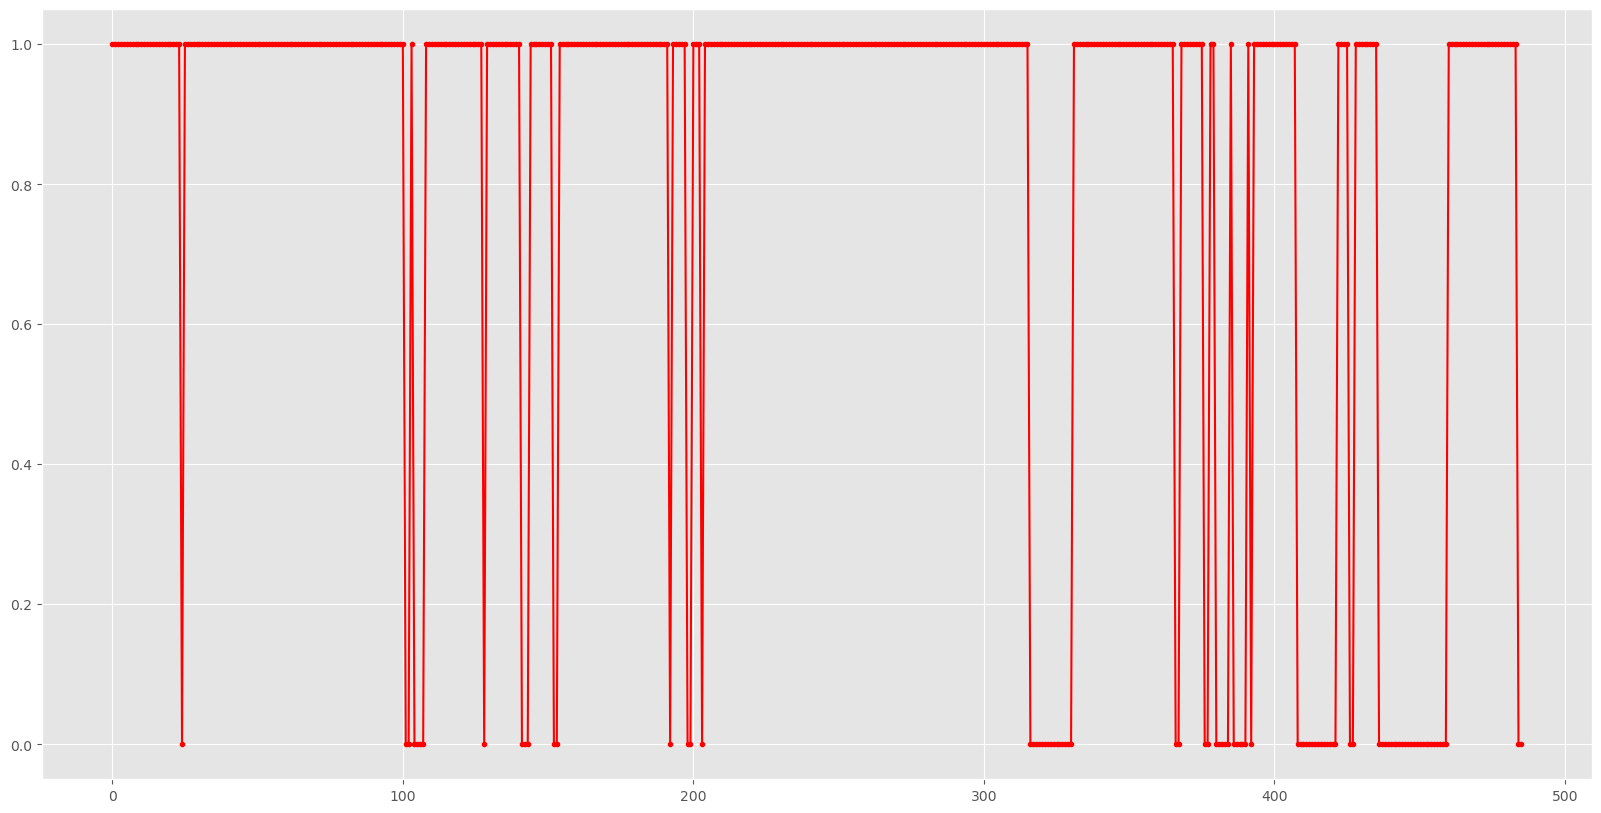

In [13]:
y_hat=test_model_c(alpha_hat_bin, beta_hat_bin,X_test_torch,thres=0.5)
evaluate(y_hat,y_test)
fig = plt.figure(figsize=(20, 10))
plt.plot(y_hat[y_test>0], 'r.-', label='test')
plt.show()


In [14]:
model__cdf,guide_cdf, alpha_hat_cdf, beta_hat_cdf=train_c_svi(model_cdf, X_train_torch, y_train_torch.squeeze(),steps=20000,lrate=0.0005)

[0] ELBO: 1819823.5
[1000] ELBO: 411308.1
[2000] ELBO: 274748.8
[3000] ELBO: 122100.6
[4000] ELBO: 66765.4
[5000] ELBO: 26286.1
[6000] ELBO: 12536.9
[7000] ELBO: 7091.1
[8000] ELBO: 5654.8
[9000] ELBO: 5164.7
[10000] ELBO: 4879.3
[11000] ELBO: 4572.9
[12000] ELBO: 4458.3
[13000] ELBO: 4389.7
[14000] ELBO: 4380.0
[15000] ELBO: 4371.5
[16000] ELBO: 4369.4
[17000] ELBO: 4370.7
[18000] ELBO: 4373.4
[19000] ELBO: 4370.5


Confusion matrix
- x-axis is true labels (no failure, failure)
- y-axis is predicted labels
[[86895    97]
 [  104   389]]
accuracy: 0.9977024632794194
precision: 0.8004115226337448
recall: 0.7890466531440162
f1 score: 0.794688457609806


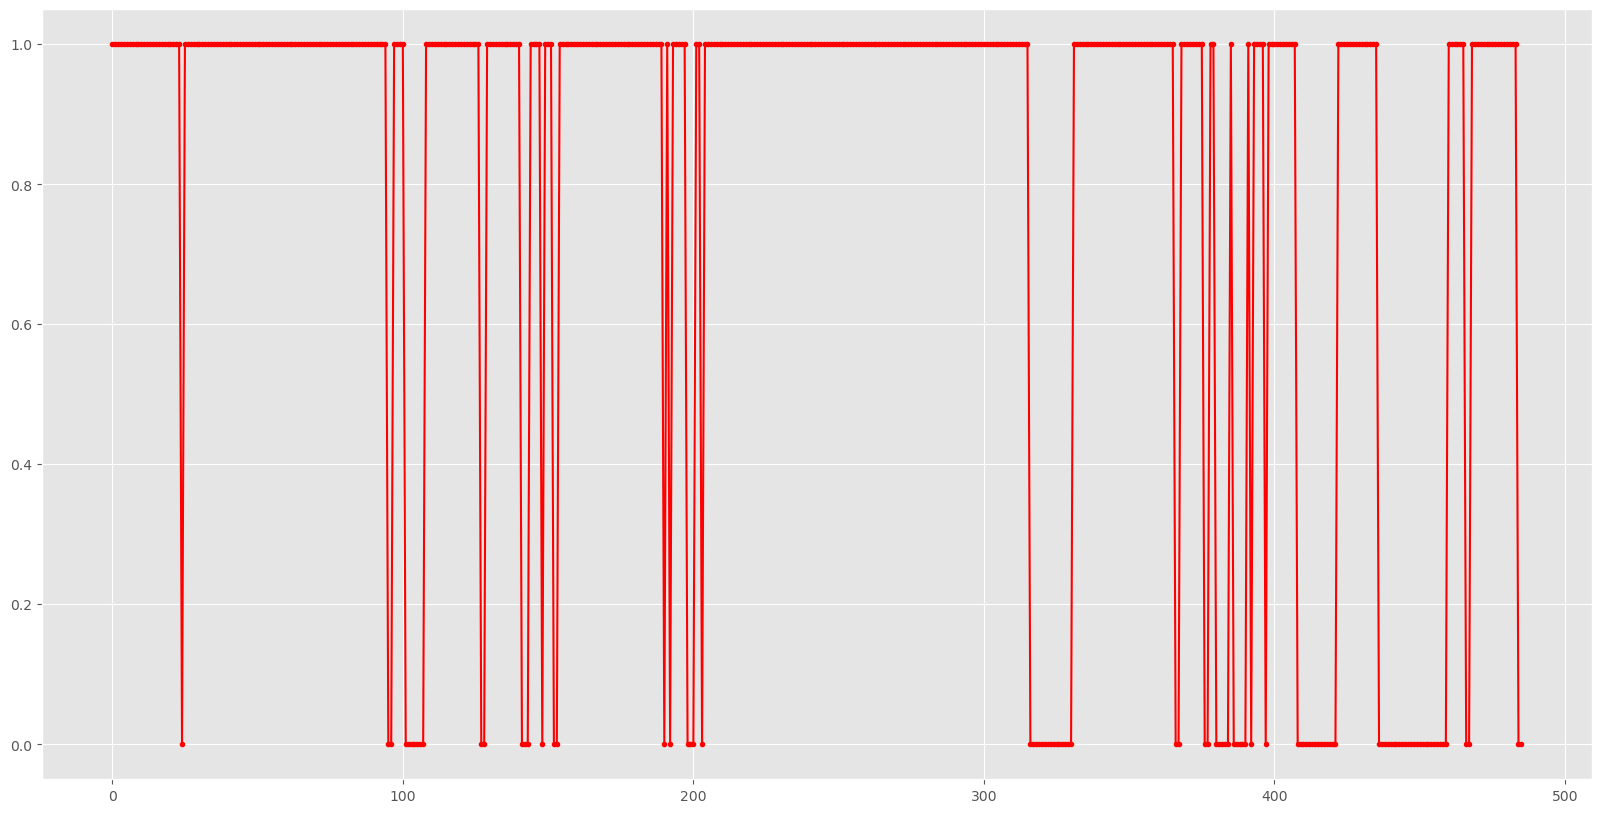

In [15]:
y_hat=test_model_c(alpha_hat_cdf, beta_hat_cdf,X_test_torch,thres=0.5)
evaluate(y_hat,y_test)
fig = plt.figure(figsize=(20, 10))
plt.plot(y_hat[y_test>0], 'r.-', label='test')
plt.show()


predictions: [0 0 0 ... 0 0 0]
true values: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.9945476367377265
labels: [0 1]
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[86881   256]
 [  221   127]]
accuracy: 0.9945476367377265
precision: 0.33159268929503916
recall: 0.3649425287356322
f1 score: 0.347469220246238


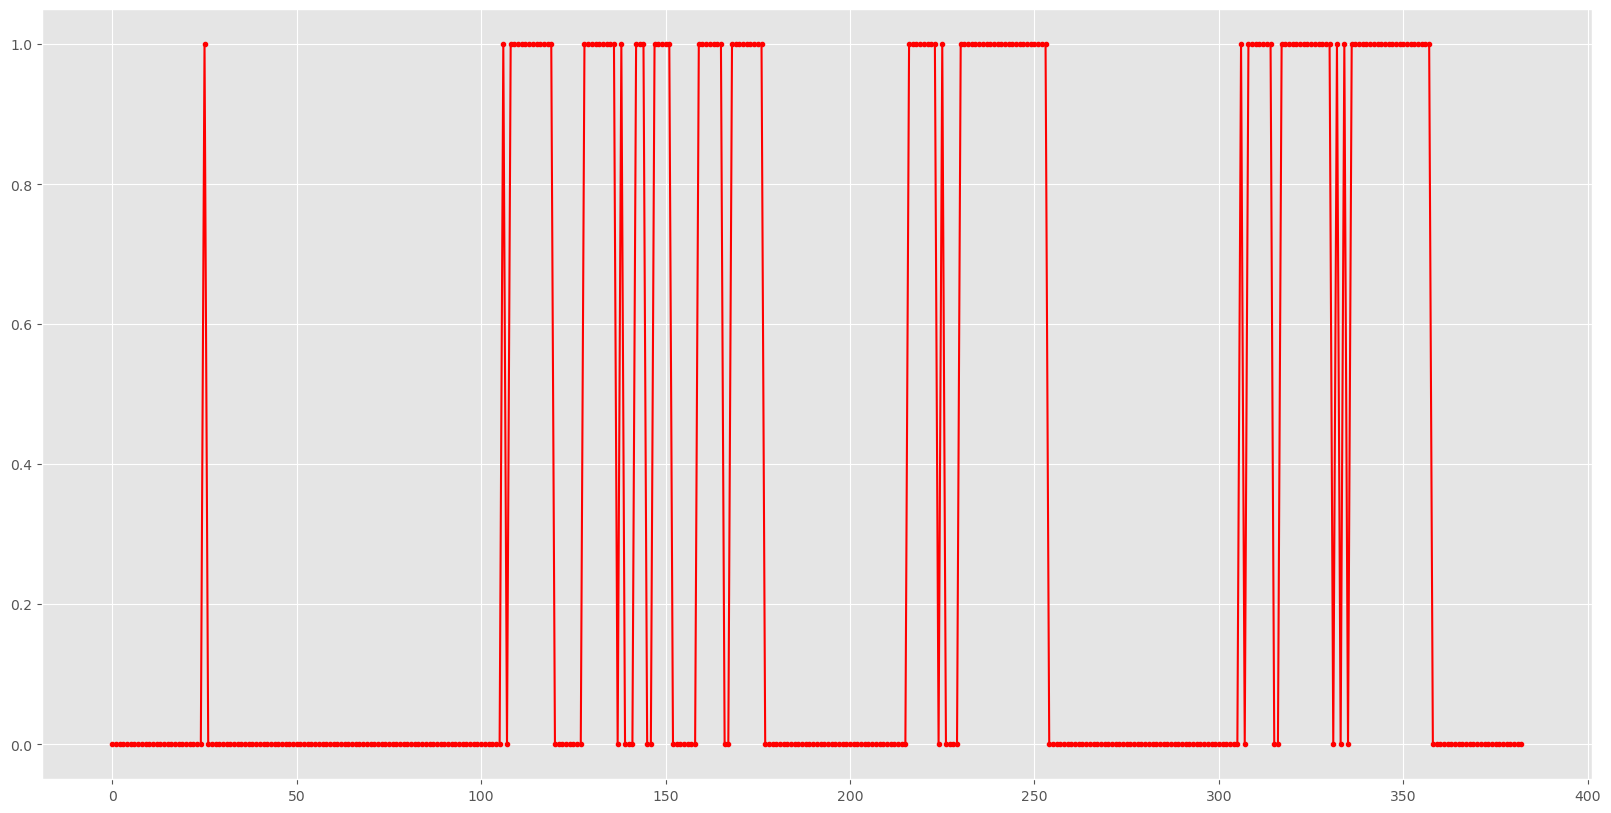

In [24]:
from src.models.test_model import plot_pred
y_hat=test_model_c(alpha_hat_cat, beta_hat_cat,X_test_torch)
test_c(y_hat,y_test)
evaluate(y_hat,y_test)
fig = plt.figure(figsize=(20, 10))

plt.plot(y_hat[y_test>0], 'r.-', label='test')

plt.show()


predictions: [0. 0. 0. ... 0. 0. 0.]
true values: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.9981121065458415


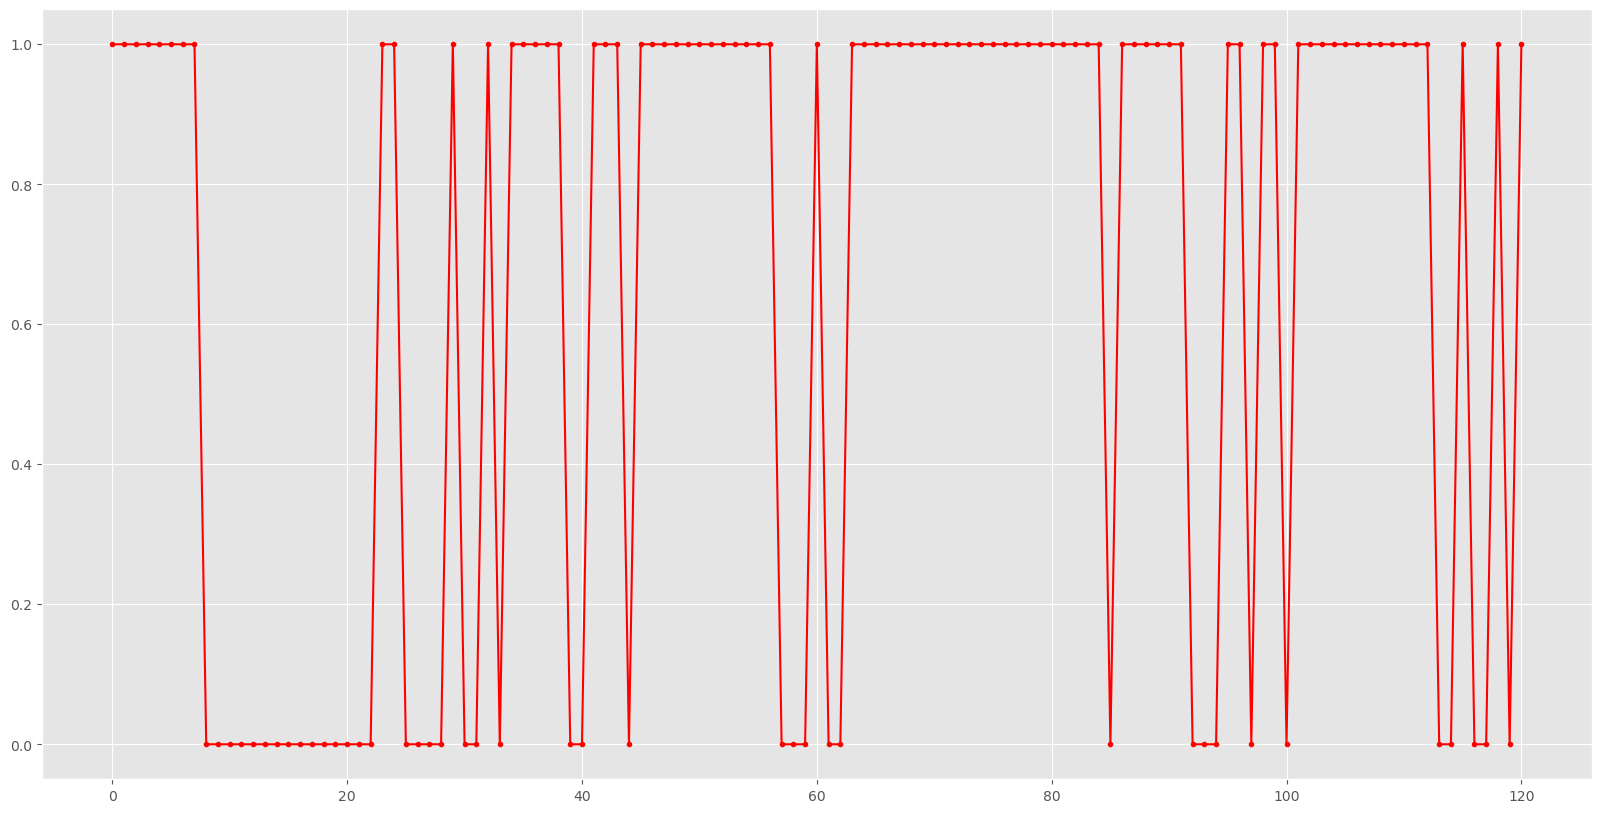

In [30]:
y_hat=test_model_c(alpha_hat_bin, beta_hat_bin,X_test_torch,thres=0.5)
test_c(y_hat,y_test)
fig = plt.figure(figsize=(20, 10))
plt.plot(y_hat[y_test>0], 'r.-', label='test')
plt.show()


predictions: [0. 0. 0. ... 0. 0. 0.]
true values: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.9873339511893728


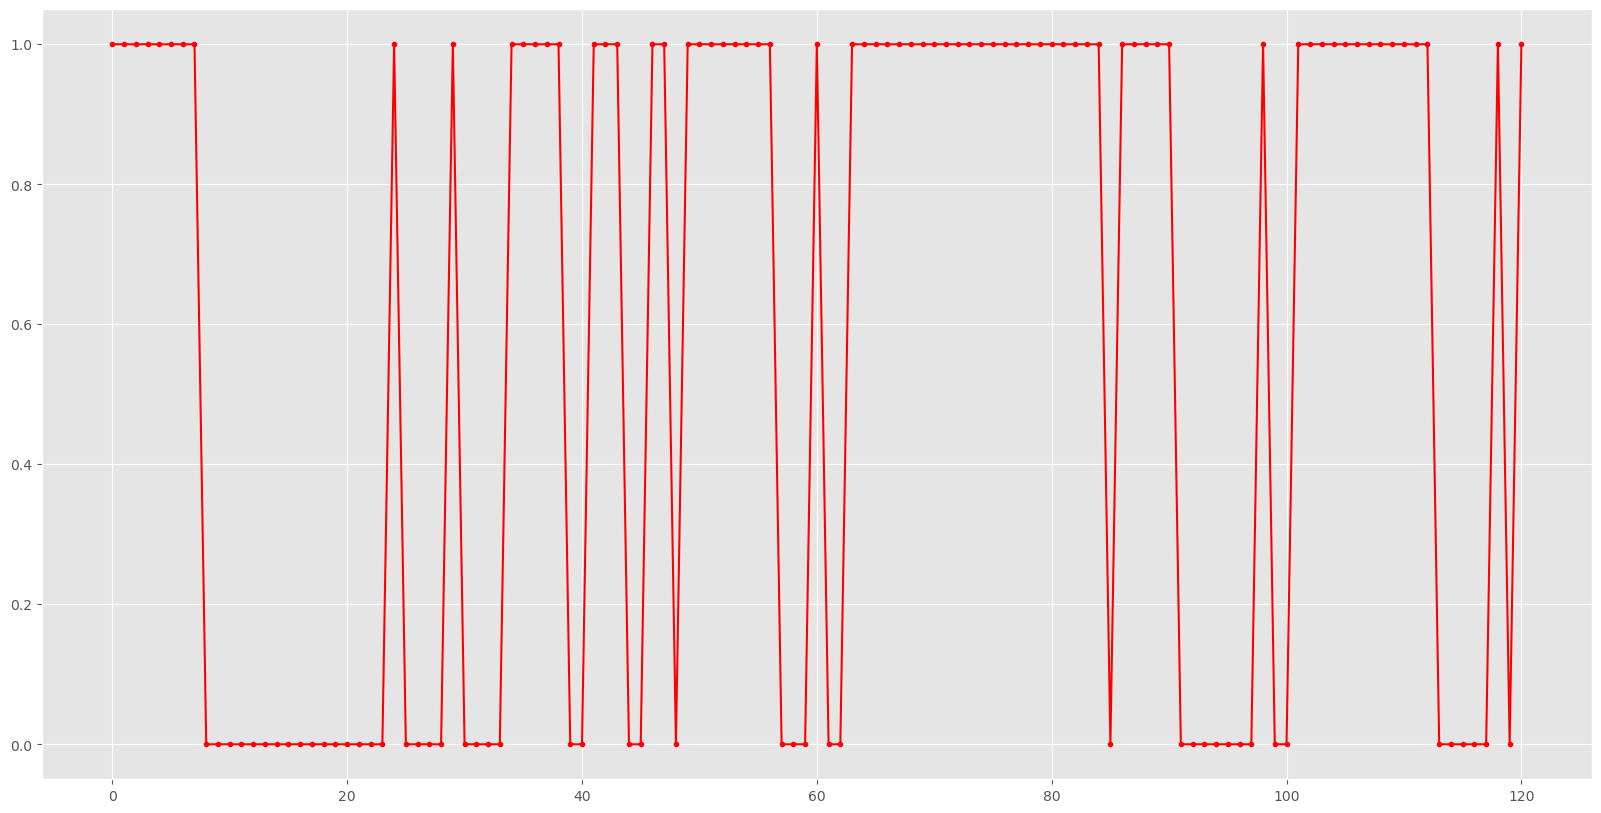

In [32]:
y_hat=test_model_c(alpha_hat_cdf, beta_hat_cdf,X_test_torch,thres=0.5)
test_c(y_hat,y_test)
fig = plt.figure(figsize=(20, 10))
plt.plot(y_hat[y_test>0], 'r.-', label='test')
plt.show()


model using mcmc

In [ ]:
from src.models.models import model_cat
from src.models.train_model import train_c_mcmc


mcmc, alpha_hat, beta_hat = train_c_mcmc(model_cat,X_train_torch, y_train_torch, num_samples=500,w_steps=100,chains=1)
y_hat=test_model_c(alpha_hat,beta_hat,X_test_torch)
test_c(y_hat,y_test)

A bit high given the range of the $y$ values...

Perhaps we can get a better intuition about the quality of the predictions of the linear regression model if we try to visualize them:

## Neural Network model in Pyro

As mentioned in the lecture's slides, we can obtain complex non-linear function of the inputs by making use of Neural Networks! The following code implements a multi-layer fully-connected NNet in Pyro. Note that, since Pyro is built on top of PyTorch, it is very well suited for building Bayesian Neural Networks and combining them with larger, more complex probabilistic graphical models. This is not the case for STAN! 

We begin by defining the neural network as a `PyroModule` instead of a PyTorch module (i.e. a class that extends ```torch.nn.Module```), as it is customary when using PyTorch for implementing deep neural networks. `PyroModule` is a subclass of `nn.Module`, which allows us to Pyro-ize an existing class (e.g. `linear_layer = PyroModule[nn.Linear](in_dim, out_dim))`) and utilize modules already created in PyTorch. Additionally, priors are placed on the weights by using `PyroSample` as illustrated below. Every neural network in PyTorch has a  `forward` function, that - implementation wise - closely resembles how you coded up Pyro models in last week's notebook.

Make sure that you understand the code above and don't hesitate to ask for clarifications! :-)

We can now perform Bayesian inference in this model (in this case using SVI) to compute the posterior distributions over the neural net weights, as we would normally do for other Pyro models:

In [ ]:
# Define guide functi
from src.models.train_model import train_nn


modelFFNN_c,guide=train_nn("modelFFNN_c", X_train_torch, y_train_torch)



After convergence, we can make predictions for the test set by again leveraging the ```Predictive``` class provided by Pyro:
Let's now calculate the MAE and compare it with the linear regression model from above:

In [41]:
from src.models.test_model import test_nn_c, test_nn_beta, mae_test, plot_pred

y_pred0=test_nn_c(modelFFNN_c,guide,X_test_torch)

test_c(y_pred0,y_test)

y_pred1=y_pred0.copy()


predictions: [0.00198558 0.00670763 0.00484606 ... 0.00898905 0.00905143 0.00342165]
true values: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.0


predictions: [0. 0. 0. ... 0. 0. 0.]
true values: [0. 0. 0. ... 0. 0. 0.]
Accuracy: 0.9810180894518243
labels: [0. 1.]
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[28579   120]
 [  433     1]]
accuracy: 0.9810180894518243
precision: 0.008264462809917356
recall: 0.002304147465437788
f1 score: 0.0036036036036036037


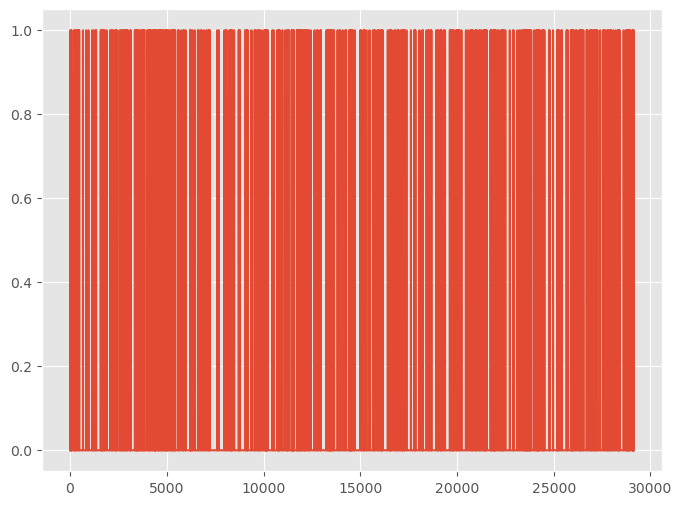

In [51]:
y_pred=y_pred1.copy()

plt.plot(y_pred)
test_c(y_pred,y_test)
evaluate(y_pred,y_test)

In [7]:
fig = plt.figure(figsize=(20, 10))

plt.plot(y_pred, 'r.-', label='test')
plt.plot(y_test, 'b-', label='pred')
plt.show()

NameError: name 'y_pred' is not defined

<Figure size 2000x1000 with 0 Axes>

We can observe that using the Pyro model above, we were able to fit a Neural Network to our non-linear dataset, and that resulted in a much lower error. For many problems where one cares only about the prediction error this could be the end of the story. However, we will do something different here.

Assume that we are actually interested in investigating how $x_1$ affects $y$ (e.g., imagine $y$ is the price of a house and $x_1$ is the square footage), but not so much about the effect of $x_2$. You could use a NNet to model the relationship of $y$ with both $x_1$ and $x_2$, however, NNets are black-boxes that are pretty hard to interpret. So, we are at a crossroads: we can either have a simple linear model (interpretable!) or a complex neural network (black-box). But can we combine both?? :-)

In order to analyse the effect of $x_1$ of $y$, we will explore the combination of PGMs and (Bayesian) Neural Networks! To do so, we will a assume a model of the following form:

\begin{align}
y = \beta \, x_1 + \mbox{NNet}(x_2) + \epsilon
\end{align}

In other words, we use a simple linear regression for modelling the relationship with $x_1$, and a Bayesian neural network for $x_2$.

Can you modify the Pyro code of the neural network above in order to implement this variation of the model?

Once you finished implementing the model above, run inference on it using SVI:


Change x1 in the model's class to something that has the highest lr weight!!!!

In [5]:
# Define guide function
from src.models.train_model import train_nn
from src.models.models import FFNN_interpretable as modelFFNN_interpretable
# Define guide function

model_FFNN_interpretable,guide=train_nn(modelFFNN_interpretable, X_train_torch, y_train_torch)


[0] ELBO: 27357652.9
[500] ELBO: 9517113.0
[1000] ELBO: 9064840.9
[1500] ELBO: 8931425.1
[2000] ELBO: 8778579.6
[2500] ELBO: 8695929.2
[3000] ELBO: 8487965.9
[3500] ELBO: 8335563.9
[4000] ELBO: 8244635.6
[4500] ELBO: 8150654.6
[5000] ELBO: 8090096.7
[5500] ELBO: 8006792.6
[6000] ELBO: 7939654.4
[6500] ELBO: 7920218.9
[7000] ELBO: 7863320.3
[7500] ELBO: 7837420.4
[8000] ELBO: 7799468.1
[8500] ELBO: 7766312.2
[9000] ELBO: 7752609.4
[9500] ELBO: 7738830.5


Let us now have a look at the estimated value for the coefficient $\beta$ over the input dimension $x_1$:

In [30]:
test_nn_beta(model_FFNN_interpretable,guide,X_test_torch)

y_pred=test_nn(model_FFNN_interpretable,guide,X_test_torch)

mae_test(y_pred,y_test)

Estimated beta: [-0.01183669]
MAE: 0.7111823337298157


Unlike with the linear regression model, we managed to recover the true value of $\beta$ that was used to generate the data ($\beta=2$)!!

What can we conclude from this? It seems that modelling more accuratly the relationship between $x_2$ and $y$ with the NNet, takes away some of the "burden" from the linear part of the model, which can then focus on modelling the effect of $x_1$ better! Makes sense, right?

But that is only part of the "story". Let us now look at the predictions for the testset:

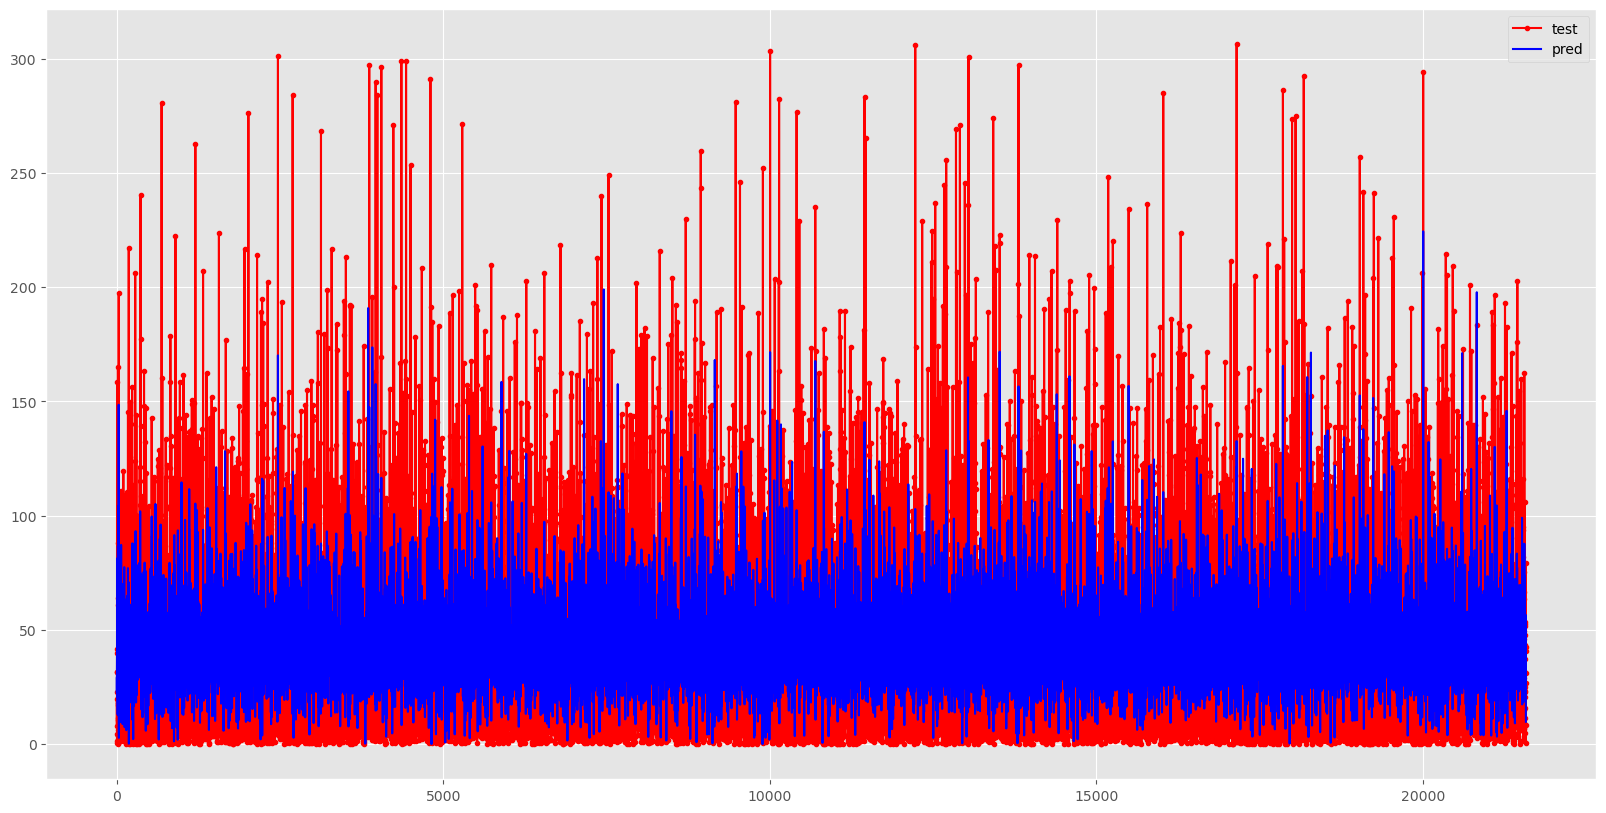

In [39]:


y_true,y_pre=plot_pred(y_pred,y_test,y_std,y_mean,0)

In [25]:
corr, mae, rae, rmse, r2, yy_true, ppreds = compute_error(y_true, y_pre, None)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

corr, mae, rae, rmse, r2, yy_true, ppreds = compute_error(y_true, y_pre, 60)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

No threshold
CorrCoef: 0.332
MAE: 27.405
RMSE: 36.367
R2: 0.097
CorrCoef: 0.085
MAE: 20.482
RMSE: 25.805
R2: 0.000


Uau! That is quite a dramatic reduction in prediction error when compared to the simple linear regression model, and we still managed to keep the interpretability over the effect of $x_1$!!

Let's see if visually we can draw a similar conclusion:

We can see that the composite model (Linear PGM + NNet) predicts almost perfectly the target variable $y$ for the testset! Notice that it managed to capture both the linear trend over the $x_1$ dimension and the complex non-linear trend on the $x_2$ dimension (the one that resulted from the sine function...).

A few more visualizations to analyse the quality of the predictions of the composite model (Linear PGM + NNet) in comparison with the predictions of the linear regression model:

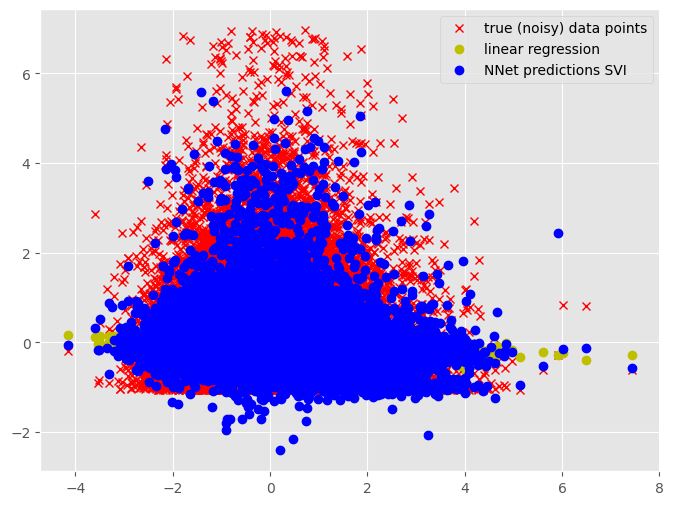

In [27]:
plt.plot(X_test[:,0], y_test, "rx")
plt.plot(X_test[:,0], preds_lr, 'yo')
plt.plot(X_test[:,0], y_pred, 'bo')
plt.legend(["true (noisy) data points", "linear regression", "NNet predictions SVI"])
plt.show()

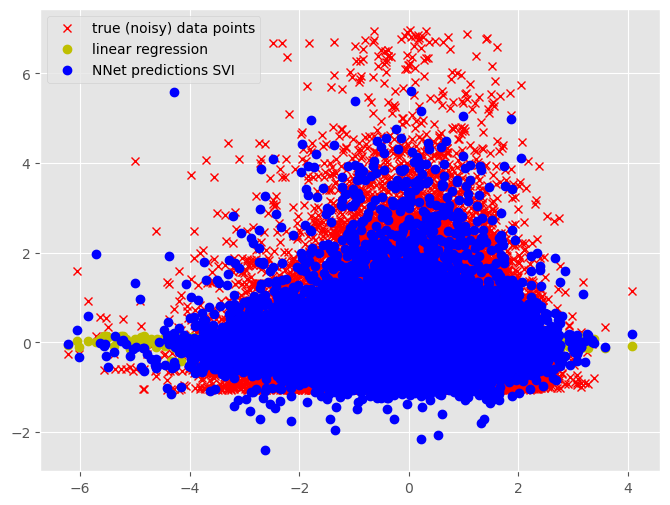

In [28]:
plt.plot(X_test[:,1], y_test, "rx")
plt.plot(X_test[:,1], preds_lr, 'yo')
plt.plot(X_test[:,1], y_pred, 'bo')
plt.legend(["true (noisy) data points", "linear regression", "NNet predictions SVI"])
plt.show()